### Opening tensorboard if necessary

In [ ]:
"""
# not working on compute4 :( 
%load_ext tensorboard
%tensorboard --logdir logs
"""

# Init: opening measurement file and creating synthetic dataset

In [2]:
# imports libraries
import time
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
import random
import datetime
import json

# my imports
from data_generation import get_sample, get_sample2 
from evals_WGANGP import evals_WGANGP
from evals_dB_WGANGP import evals_dB_WGANGP
from evecs_WGANGP import evecs_WGANGP
from main_evecs_WGANGP import main_evecs_WGANGP
from noise_evecs_WGANGP import noise_evecs_WGANGP
from measurement import get_measurement_sample
from eigenmanipulation import normalize_evals, normalize_evecs, levelify, unlevelify
from beamforming import beamform, get_csm

# config files
from msm_config2022 import FILES, LOC # config file for measurements with names 2022- ... .h5

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-o01dvejk because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
"""
start = time.time()

filename_examples = ["2022-01-26_16-44-23_105567.h5",
                    "2022-01-26_16-37-41_557896.h5",
                    "2022-01-26_16-41-15_436578.h5",
                    "2022-01-26_16-27-11_017085.h5",
                    "2022-01-26_16-21-22_252111.h5",
                    "2022-01-26_16-21-05_110135.h5",
                    "2022-01-26_16-18-19_438409.h5"]


# General variable
BATCH_SIZE = 16
NB_SYNTHETIC_BATCH = 1000 # for the synthetic dataset
NB_MEASUREMENT_BATCH = 200 # for the measurement dataset
NB_STEPS = 5

# Variables to access the measurements
MEASUREMENT_PATH = "../Data/Measurement/td/"
MEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"
FILENAME = filename_examples[np.random.randint(len(filename_examples))]
print(f"measurement used: {FILENAME[:-3]}")
MEASUREMENT_NAME = f"{MEASUREMENT_PATH}{FILENAME}"

# Data to use
loc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}
loc = loc_dict[FILENAME]
LOCATION=(loc[0], loc[1], 0.5) # location of the sound source
FREQ_INDEX = 63
BLOCKSIZE = 128
APERTURE_SIZE = 1.5 # measurement
SPEED_OF_SOUND = 343 #[m/s]
SAMPLING_FREQUENCY = 51200 # measurement 2022
FREQ = (SAMPLING_FREQUENCY*FREQ_INDEX)/BLOCKSIZE
HELMOTZ_NUMBER_MEASUREMENT = (FREQ*APERTURE_SIZE)/SPEED_OF_SOUND
HELMOTZ_NUMBER_SYNTHETIC = FREQ/SPEED_OF_SOUND



# Generating synthetic dataset
synthetic_dataset = [get_sample2(loc=LOCATION, 
                                 helmotz_number=HELMOTZ_NUMBER_SYNTHETIC)
                     for _ in range(BATCH_SIZE*NB_SYNTHETIC_BATCH)]

main_evecs_dataset = tf.convert_to_tensor([s[0] for s in synthetic_dataset])
noise_evecs_dataset = tf.convert_to_tensor([s[1] for s in synthetic_dataset])
evals_dataset = tf.convert_to_tensor([s[2] for s in synthetic_dataset])
evals_dB_dataset = tf.convert_to_tensor([s[3] for s in synthetic_dataset])

# Opening measurement dataset
measurement_dataset = [get_measurement_sample(measurement_name=MEASUREMENT_NAME,
                                             freq_index=FREQ_INDEX)
                       for _ in range(BATCH_SIZE*NB_MEASUREMENT_BATCH)]

measurement_main_evecs_dataset = tf.convert_to_tensor([m[0] for m in measurement_dataset])
measurement_noise_evecs_dataset = tf.convert_to_tensor([m[1] for m in measurement_dataset])
measurement_evals_dataset = tf.convert_to_tensor([m[2] for m in measurement_dataset])
measurement_evals_dB_dataset = tf.convert_to_tensor([m[3] for m in measurement_dataset])

diff = time.time() - start
print(f"completed in {diff}s")
"""
# On computer4, for: BATCH_SIZE = 16, NB_SYNTHETIC_BATCH = 500, NB_MEASUREMENT_BATCH = 100 --> completed in approx. 30min

'\nstart = time.time()\n\nfilename_examples = ["2022-01-26_16-44-23_105567.h5",\n                    "2022-01-26_16-37-41_557896.h5",\n                    "2022-01-26_16-41-15_436578.h5",\n                    "2022-01-26_16-27-11_017085.h5",\n                    "2022-01-26_16-21-22_252111.h5",\n                    "2022-01-26_16-21-05_110135.h5",\n                    "2022-01-26_16-18-19_438409.h5"]\n\n\n# General variable\nBATCH_SIZE = 16\nNB_SYNTHETIC_BATCH = 1000 # for the synthetic dataset\nNB_MEASUREMENT_BATCH = 200 # for the measurement dataset\nNB_STEPS = 5\n\n# Variables to access the measurements\nMEASUREMENT_PATH = "../Data/Measurement/td/"\nMEASUREMENT_PATH_C4 = "../../../shared/measured_data/td/"\nFILENAME = filename_examples[np.random.randint(len(filename_examples))]\nprint(f"measurement used: {FILENAME[:-3]}")\nMEASUREMENT_NAME = f"{MEASUREMENT_PATH}{FILENAME}"\n\n# Data to use\nloc_dict = {f"{name}.h5": loc for name, loc in zip(FILES, LOC)}\nloc = loc_dict[FILENAME]\nLO

### Misc: function to save and load datasets instead of generating them

In [4]:
# Save datasets:
"""
datasets = [main_evecs_dataset,
            noise_evecs_dataset,
            evals_dataset,
            evals_dB_dataset,
            measurement_main_evecs_dataset,
            measurement_noise_evecs_dataset,
            measurement_evals_dataset,
            measurement_evals_dB_dataset]

name_datasets = ["main_evecs_dataset",
                "noise_evecs_dataset",
                "evals_dataset",
                "evals_dB_dataset",
                "measurement_main_evecs_dataset",
                "measurement_noise_evecs_dataset",
                "measurement_evals_dataset",
                "measurement_evals_dB_dataset"]

for dataset, name in zip(datasets, name_datasets):
    numpy_dataset = np.array(dataset)
    with open(f'datasets_backups/{name}.npy', 'wb') as f:
        np.save(f, numpy_dataset)
        
        
# Save variables:
variable_dict = {
        "BATCH_SIZE":BATCH_SIZE,
        "NB_SYNTHETIC_BATCH":NB_SYNTHETIC_BATCH,
        "NB_MEASUREMENT_BATCH":NB_MEASUREMENT_BATCH,
        "NB_STEPS":NB_STEPS,
        "MEASUREMENT_PATH":MEASUREMENT_PATH,
        "MEASUREMENT_PATH_C4":MEASUREMENT_PATH_C4,
        "FILENAME":FILENAME,
        "MEASUREMENT_NAME":MEASUREMENT_NAME,
        "LOCATION":LOCATION,
        "FREQ_INDEX":FREQ_INDEX,
        "BLOCKSIZE":BLOCKSIZE,
        "APERTURE_SIZE":APERTURE_SIZE,
        "SPEED_OF_SOUND":SPEED_OF_SOUND,
        "SAMPLING_FREQUENCY":SAMPLING_FREQUENCY,
        "FREQ":FREQ,
        "HELMOTZ_NUMBER_MEASUREMENT":HELMOTZ_NUMBER_MEASUREMENT,
        "HELMOTZ_NUMBER_SYNTHETIC":HELMOTZ_NUMBER_SYNTHETIC
}

variable_dict_json = json.dumps(variable_dict)

with open("datasets_backups/variable_dict.json","w") as f:
    f.write(variable_dict_json)
"""

'\ndatasets = [main_evecs_dataset,\n            noise_evecs_dataset,\n            evals_dataset,\n            evals_dB_dataset,\n            measurement_main_evecs_dataset,\n            measurement_noise_evecs_dataset,\n            measurement_evals_dataset,\n            measurement_evals_dB_dataset]\n\nname_datasets = ["main_evecs_dataset",\n                "noise_evecs_dataset",\n                "evals_dataset",\n                "evals_dB_dataset",\n                "measurement_main_evecs_dataset",\n                "measurement_noise_evecs_dataset",\n                "measurement_evals_dataset",\n                "measurement_evals_dB_dataset"]\n\nfor dataset, name in zip(datasets, name_datasets):\n    numpy_dataset = np.array(dataset)\n    with open(f\'datasets_backups/{name}.npy\', \'wb\') as f:\n        np.save(f, numpy_dataset)\n        \n        \n# Save variables:\nvariable_dict = {\n        "BATCH_SIZE":BATCH_SIZE,\n        "NB_SYNTHETIC_BATCH":NB_SYNTHETIC_BATCH,\n        "NB_M

In [3]:
# Load from backup instead
with open(f'datasets_backups/main_evecs_dataset.npy', 'rb') as f:
    main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/noise_evecs_dataset.npy', 'rb') as f:
    noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dataset.npy', 'rb') as f:
    evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/evals_dB_dataset.npy', 'rb') as f:
    evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_main_evecs_dataset.npy', 'rb') as f:
    measurement_main_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_noise_evecs_dataset.npy', 'rb') as f:
    measurement_noise_evecs_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dataset.npy', 'rb') as f:
    measurement_evals_dataset = tf.convert_to_tensor(np.load(f))
    
with open(f'datasets_backups/measurement_evals_dB_dataset.npy', 'rb') as f:
    measurement_evals_dB_dataset = tf.convert_to_tensor(np.load(f))
    
# Load variable:
with open("datasets_backups/variable_dict.json","r") as f:
    variable_dict = json.load(f)

BATCH_SIZE = variable_dict["BATCH_SIZE"]
NB_SYNTHETIC_BATCH = variable_dict["NB_SYNTHETIC_BATCH"]
NB_MEASUREMENT_BATCH = variable_dict["NB_MEASUREMENT_BATCH"]
NB_STEPS = variable_dict["NB_STEPS"]
MEASUREMENT_PATH = variable_dict["MEASUREMENT_PATH"]
MEASUREMENT_PATH_C4 = variable_dict["MEASUREMENT_PATH_C4"]
FILENAME = variable_dict["FILENAME"]
MEASUREMENT_NAME = variable_dict["MEASUREMENT_NAME"]
LOCATION = variable_dict["LOCATION"]
FREQ_INDEX = variable_dict["FREQ_INDEX"]
BLOCKSIZE = variable_dict["BLOCKSIZE"]
APERTURE_SIZE = variable_dict["APERTURE_SIZE"]
SPEED_OF_SOUND = variable_dict["SPEED_OF_SOUND"]
SAMPLING_FREQUENCY = variable_dict["SAMPLING_FREQUENCY"]
FREQ = variable_dict["FREQ"]
HELMOTZ_NUMBER_MEASUREMENT = variable_dict["HELMOTZ_NUMBER_MEASUREMENT"]
HELMOTZ_NUMBER_SYNTHETIC = variable_dict["HELMOTZ_NUMBER_SYNTHETIC"]

In [3]:
# Print dimension of datasets and variable

print("")
print("=== Datasets ==============================================")
print("")

print(f"main_evecs_dataset.shape: {main_evecs_dataset.shape}")
print(f"noise_evecs_dataset.shape: {noise_evecs_dataset.shape}")
print(f"evals_dataset.shape: {evals_dataset.shape}")
print(f"evals_dB_dataset.shape: {evals_dB_dataset.shape}")
print(f"measurement_noise_evecs_dataset.shape: {measurement_noise_evecs_dataset.shape}")
print(f"measurement_noise_evecs_dataset.shape: {measurement_noise_evecs_dataset.shape}")
print(f"measurement_evals_dataset.shape: {measurement_evals_dataset.shape}")
print(f"measurement_evals_dB_dataset.shape: {measurement_evals_dB_dataset.shape}")

print("")
print("")
print("=== Variables =============================================")
print("")

print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"NB_SYNTHETIC_BATCH: {NB_SYNTHETIC_BATCH}")
print(f"NB_MEASUREMENT_BATCH: {NB_MEASUREMENT_BATCH}")
print(f"NB_STEPS: {NB_STEPS}")
print(f"MEASUREMENT_PATH: {MEASUREMENT_PATH}")
print(f"MEASUREMENT_PATH_C4: {MEASUREMENT_PATH_C4}")
print(f"FILENAME: {FILENAME}")
print(f"MEASUREMENT_NAME: {MEASUREMENT_NAME}")
print(f"LOCATION: {LOCATION}")
print(f"FREQ_INDEX: {FREQ_INDEX}")
print(f"BLOCKSIZE: {BLOCKSIZE}")
print(f"APERTURE_SIZE: {APERTURE_SIZE}")
print(f"SPEED_OF_SOUND: {SPEED_OF_SOUND}")
print(f"SAMPLING_FREQUENCY: {SAMPLING_FREQUENCY}")
print(f"FREQ: {FREQ}")
print(f"HELMOTZ_NUMBER_MEASUREMENT: {HELMOTZ_NUMBER_MEASUREMENT}")
print(f"HELMOTZ_NUMBER_SYNTHETIC: {HELMOTZ_NUMBER_SYNTHETIC}")




=== Datasets ==============================================

main_evecs_dataset.shape: (16000, 1, 64, 2)
noise_evecs_dataset.shape: (16000, 63, 64, 2)
evals_dataset.shape: (16000, 8, 8, 1)
evals_dB_dataset.shape: (16000, 8, 8, 1)
measurement_noise_evecs_dataset.shape: (3200, 63, 64, 2)
measurement_noise_evecs_dataset.shape: (3200, 63, 64, 2)
measurement_evals_dataset.shape: (3200, 8, 8, 1)
measurement_evals_dB_dataset.shape: (3200, 8, 8, 1)


=== Variables =============================================

BATCH_SIZE: 16
NB_SYNTHETIC_BATCH: 1000
NB_MEASUREMENT_BATCH: 200
NB_STEPS: 5
MEASUREMENT_PATH: ../Data/Measurement/td/
MEASUREMENT_PATH_C4: ../../../shared/measured_data/td/
FILENAME: 2022-01-26_16-27-11_017085.h5
MEASUREMENT_NAME: ../Data/Measurement/td/2022-01-26_16-27-11_017085.h5
LOCATION: [-0.09, -0.111, 0.5]
FREQ_INDEX: 63
BLOCKSIZE: 128
APERTURE_SIZE: 1.5
SPEED_OF_SOUND: 343
SAMPLING_FREQUENCY: 51200
FREQ: 25200.0
HELMOTZ_NUMBER_MEASUREMENT: 110.20408163265306
HELMOTZ_NUMBER_SYN

# Printing examples from datasets

### Examples of eigenvalues from both datasets 

index=14578
index=70


Text(0.5, 0.98, 'Eigenvalues from dataset')

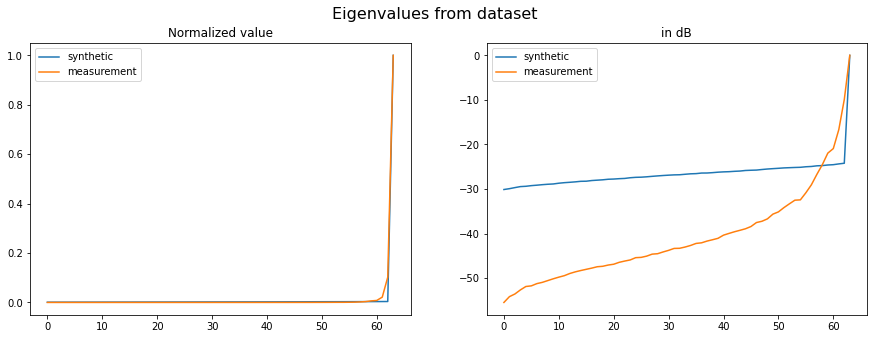

In [4]:
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex, label="synthetic")
plt.plot(measurement_evals_ex, label="measurement")
plt.legend()

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB, label="synthetic")
plt.plot(measurement_evals_ex_dB, label="measurement")
plt.legend()

fig.suptitle('Eigenvalues from dataset', fontsize=16)

### Examples of eigenvectors from synthetic dataset 

index=3068


Text(0.5, 0.98, 'Eigenvectors from synthetic dataset')

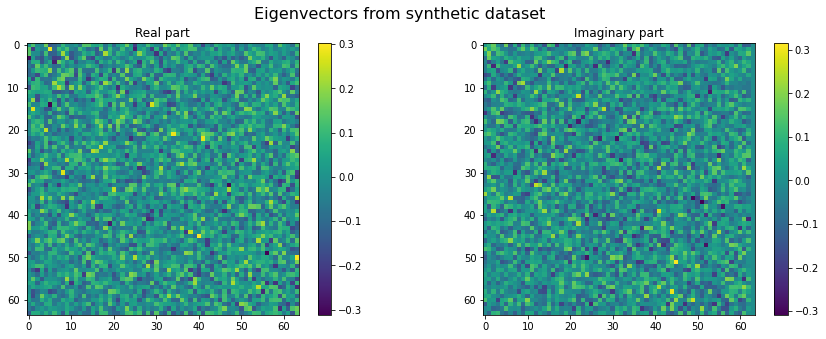

In [5]:
last_index = min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = noise_evecs_dataset[random_index]
main_evec_ex = main_evecs_dataset[random_index]

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)

evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real).T)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag).T)
plt.colorbar()

fig.suptitle('Eigenvectors from synthetic dataset', fontsize=16)

### Examples of eigenvectors from measurement dataset

index=880


Text(0.5, 0.98, 'Eigenvectors from measurement dataset')

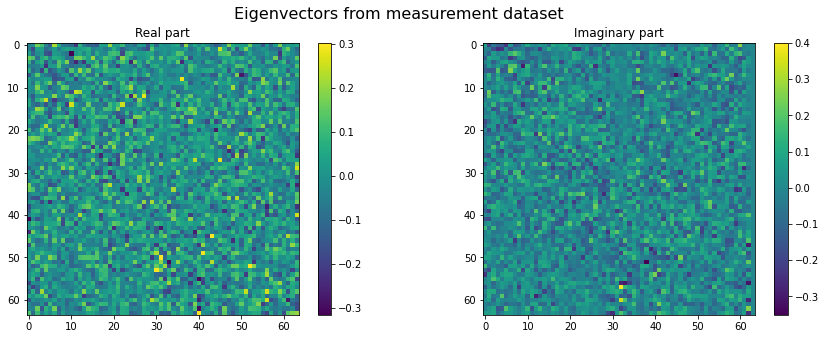

In [8]:
last_index = min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0])-1

random_index = random.randint(0, last_index)
print(f"index={random_index}")

noise_evec_ex = measurement_noise_evecs_dataset[random_index]
main_evec_ex = measurement_main_evecs_dataset[random_index]

#print(main_evec_ex)

evec_ex = tf.concat([noise_evec_ex, main_evec_ex],axis=-3)
evec_ex = normalize_evecs(evec_ex)

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(np.array(evec_ex_real).T)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(np.array(evec_ex_imag).T)
plt.colorbar()

fig.suptitle('Eigenvectors from measurement dataset', fontsize=16)

### Plotting histogram of vectors

In [9]:
# Function for plotting histogram:
def histogram_single_vector(dataset, decimals=2, vector_index=-1):
    size_measurement  = dataset.shape[0]
    nb_noise_vectors = dataset.shape[1]
    
    if not (vector_index >= 0 and vector_index < nb_noise_vectors):
        vector_index = np.random.randint(nb_noise_vectors)
        print(f"vector_index={vector_index}")
    
    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    
    

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,vector_index,:,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,vector_index,:,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count

    fig = plt.figure(figsize=(20,10))

    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    
def histogram_all_vectors(dataset, decimals=2):
    size_measurement  = dataset.shape[0]
    nb_noise_vectors = dataset.shape[1]

    resolution = 10**decimals
    bins = np.arange(-resolution,resolution+1, dtype=int)/resolution

    a_real_sum = np.zeros(shape=bins.shape)
    a_imag_sum = np.zeros(shape=bins.shape)

    for i in range(size_measurement):
        a_real = np.round(np.array(dataset[i,:,:,0]).flatten(), decimals=decimals)
        a_imag = np.round(np.array(dataset[i,:,:,1]).flatten(), decimals=decimals)

        a_real_count = np.array([np.sum(a_real == b) for b in bins])
        a_imag_count = np.array([np.sum(a_imag == b) for b in bins])

        a_real_sum = a_real_sum + a_real_count
        a_imag_sum = a_imag_sum + a_imag_count


    fig = plt.figure(figsize=(20,10))

    plt.subplot(1,2,1)
    _ = plt.hist(bins, bins, weights=a_real_sum)

    plt.subplot(1,2,2)
    _ = plt.hist(bins, bins, weights=a_imag_sum)
    

1. Measurement main eigenvector

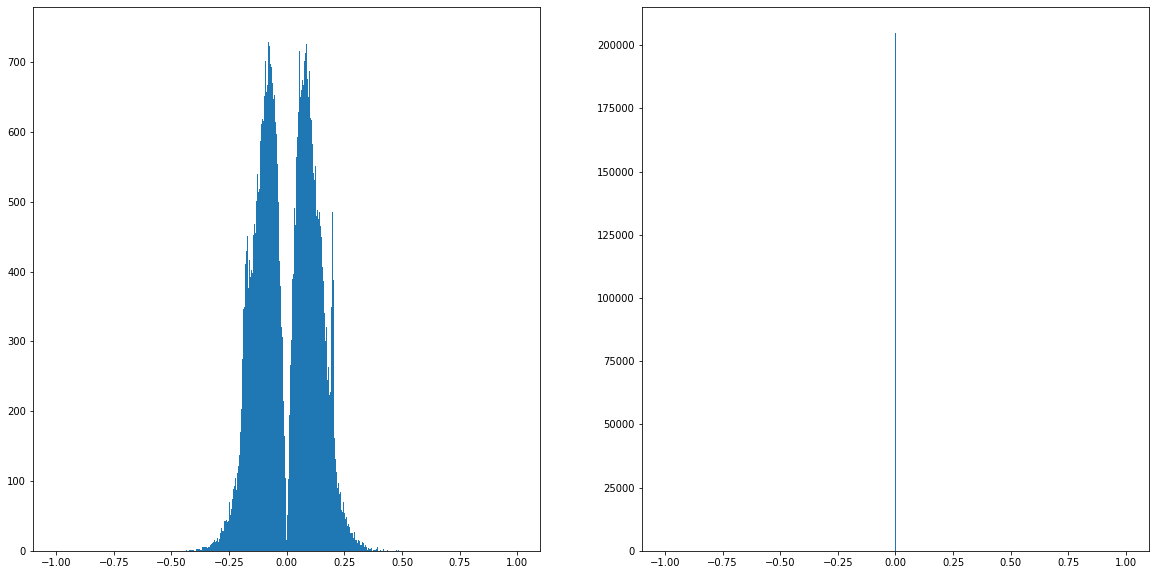

In [106]:
histogram_single_vectors(measurement_main_evecs_dataset, decimals=3, vector_index=0)

2. Synthetic main eigenvector

vector_index=0


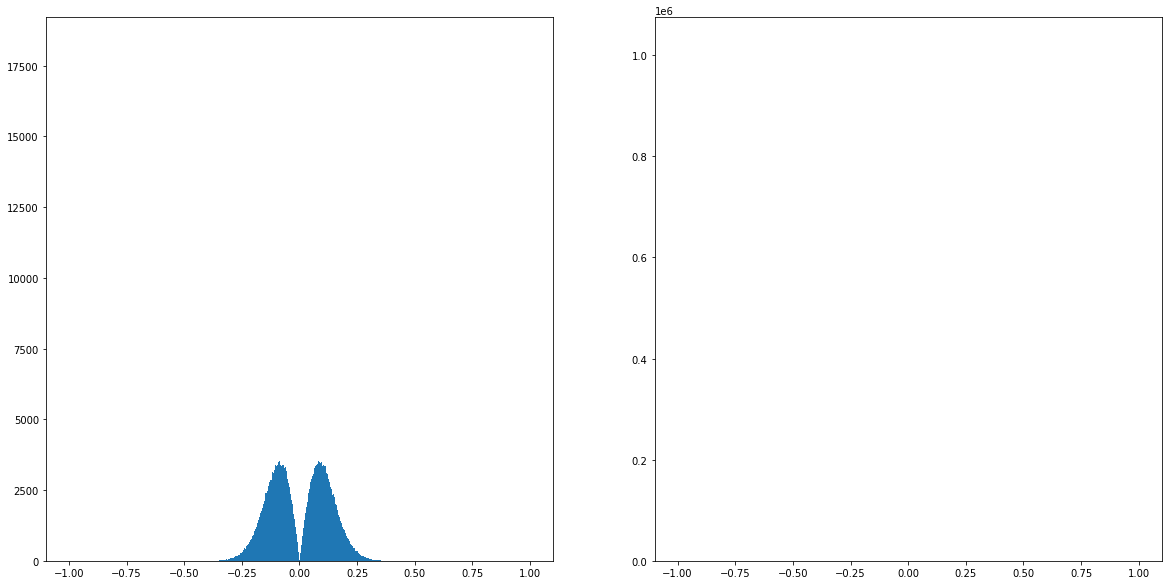

In [109]:
histogram_single_vector(main_evecs_dataset, decimals=3, vector_index=0)

3. All measurement noise eigenvectors

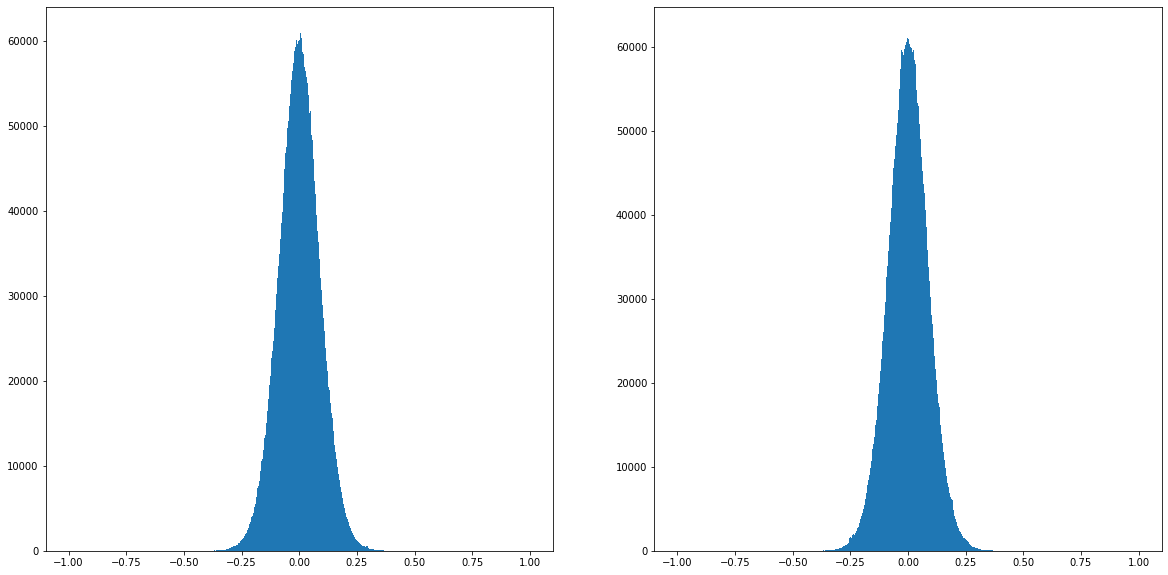

In [110]:
histogram_all_vectors(measurement_noise_evecs_dataset, decimals=3)

4. All synthetic noise eigenvectors

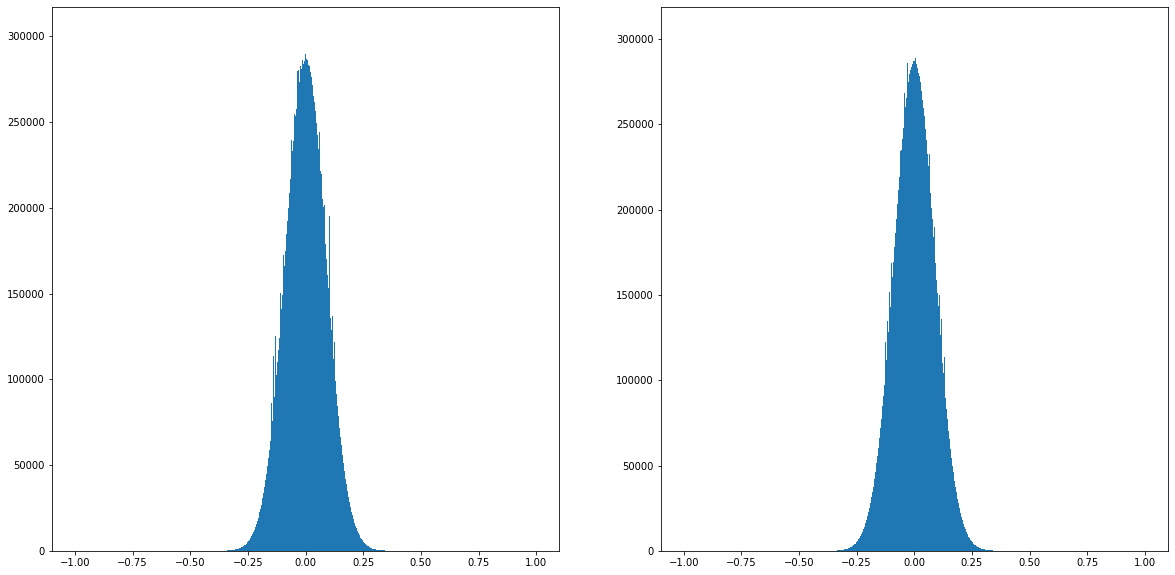

In [111]:
histogram_all_vectors(noise_evecs_dataset, decimals=3)

5. Only one measurement noise eigenvector (selected at random)

vector_index=10


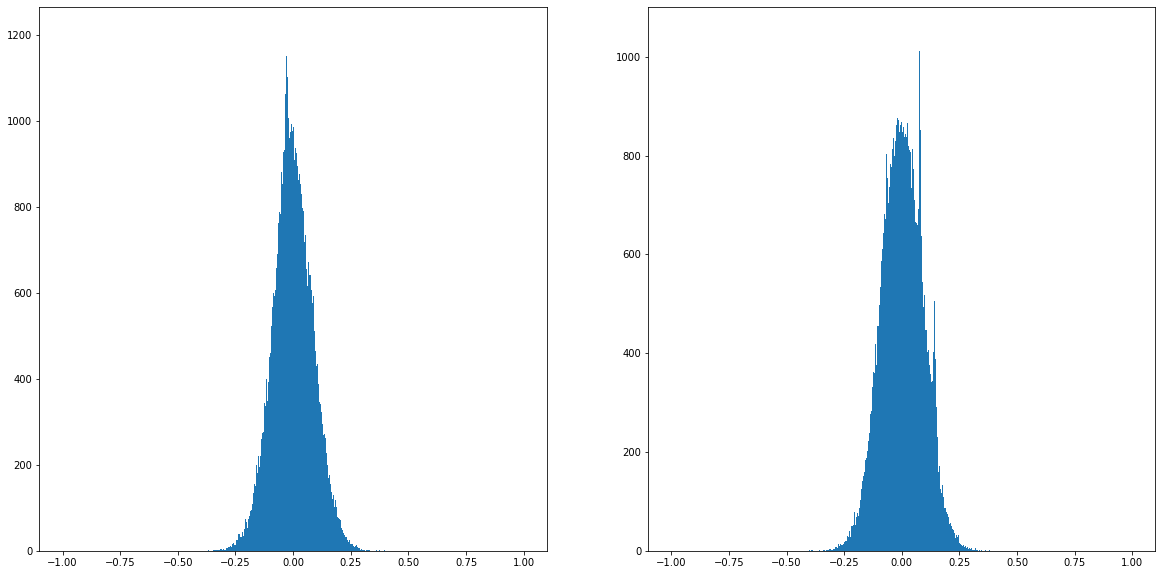

In [114]:
histogram_single_vector(measurement_noise_evecs_dataset, decimals=3, vector_index=-1)

6. Only one synthetic noise eigenvector (selected at random)

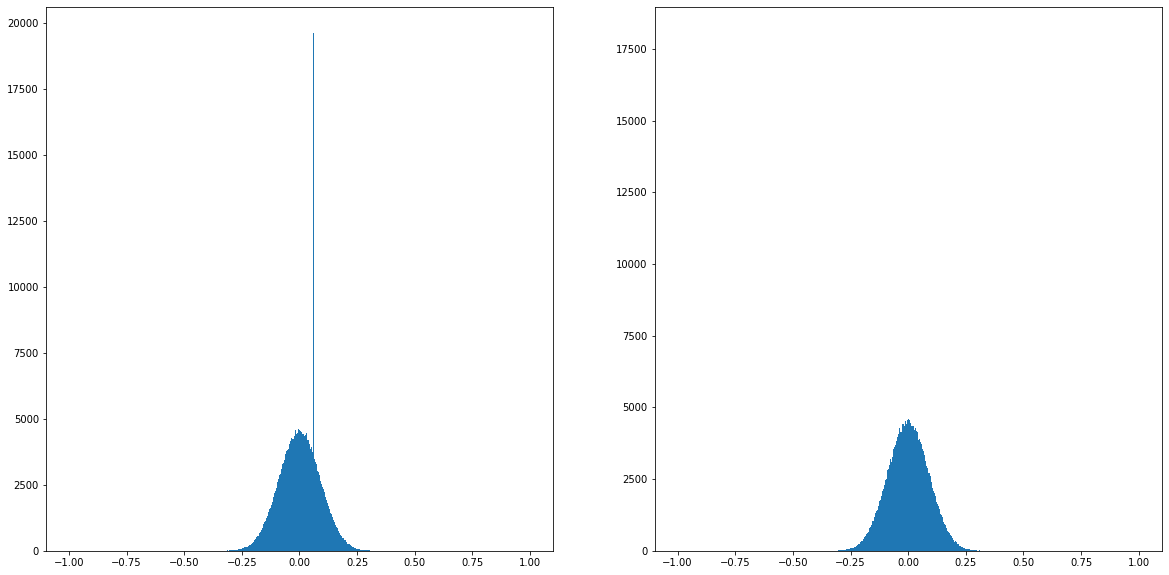

In [121]:
histogram_single_vector(noise_evecs_dataset, decimals=3, vector_index=-1)

### Beamforming example: synthetic dataset

index=3555


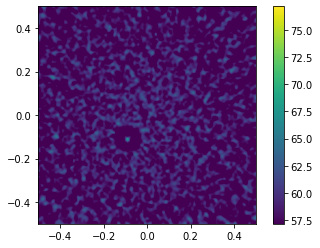

In [11]:
last_index = min(min(main_evecs_dataset.shape[0], noise_evecs_dataset.shape[0]), evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = evals_dataset[random_index]
noise_evecs_ex = noise_evecs_dataset[random_index]
main_evecs_ex = main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER_SYNTHETIC, measurement=False)

### Beamforming example: measurement set

index=3108


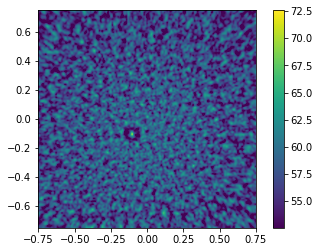

In [10]:
last_index = min(min(measurement_main_evecs_dataset.shape[0], measurement_noise_evecs_dataset.shape[0]), measurement_evals_dataset.shape[0])-1
random_index = random.randint(0, last_index)
print(f"index={random_index}")


evals_ex = measurement_evals_dataset[random_index]
noise_evecs_ex = measurement_noise_evecs_dataset[random_index]
main_evecs_ex = measurement_main_evecs_dataset[random_index]
evecs_ex = tf.concat([noise_evecs_ex, main_evecs_ex], axis=-3)

# Normalizing
evals_ex  = normalize_evals(evals_ex)
evecs_ex  = normalize_evecs(evecs_ex)

# reshape data
evals_vec_numpy = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = evecs_ex[:, :, 0] # get real part from sample
evecs_imag = evecs_ex[:, :, 1] # get imaginary part from sample

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm, helmotz_number=HELMOTZ_NUMBER_MEASUREMENT, measurement=True)

# Generating data
### Generating eigenvalues from regular values
First step is creating the Wasserstein GAN and training it with synthetic data

In [12]:
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Getting directories for callbacks
filename = "evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )

# Training GAN
evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_SYNTHETIC_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)



# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257  

5/5 [==============================] - 0s 8ms/step - c_loss: -0.1701 - g_loss: -0.0568
Epoch 135/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1655 - g_loss: -0.0712
Epoch 136/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1761 - g_loss: -0.0700
Epoch 137/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1716 - g_loss: -0.0746
Epoch 138/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1581 - g_loss: -0.0814
Epoch 139/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1589 - g_loss: -0.0849
Epoch 140/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1644 - g_loss: -0.0836
Epoch 141/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1582 - g_loss: -0.0792
Epoch 142/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1637 - g_loss: -0.0753
Epoch 143/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1603 - g_loss: -0.

5/5 [==============================] - 0s 9ms/step - c_loss: -0.0511 - g_loss: -0.2657
Epoch 295/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0309 - g_loss: -0.2610
Epoch 296/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0460 - g_loss: -0.2711
Epoch 297/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0360 - g_loss: -0.2575
Epoch 298/1000
5/5 [==============================] - 0s 6ms/step - c_loss: -0.0478 - g_loss: -0.2322
Epoch 299/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0445 - g_loss: -0.2263
Epoch 300/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0468 - g_loss: -0.2518
Epoch 301/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0437 - g_loss: -0.2487
Epoch 302/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0397 - g_loss: -0.2506
Epoch 303/1000
5/5 [==============================] - 0s 6ms/step - c_loss: -0.0419 - g_loss: -0.

5/5 [==============================] - 0s 7ms/step - c_loss: -0.0221 - g_loss: -0.3174
Epoch 455/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0206 - g_loss: -0.3079
Epoch 456/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0285 - g_loss: -0.2889
Epoch 457/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0186 - g_loss: -0.2444
Epoch 458/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0270 - g_loss: -0.2540
Epoch 459/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0301 - g_loss: -0.2831
Epoch 460/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0234 - g_loss: -0.3240
Epoch 461/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0232 - g_loss: -0.3356
Epoch 462/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0158 - g_loss: -0.3039
Epoch 463/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0015 - g_loss: -

5/5 [==============================] - 0s 9ms/step - c_loss: -0.0130 - g_loss: -0.2399
Epoch 615/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0192 - g_loss: -0.2579
Epoch 616/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0165 - g_loss: -0.2787
Epoch 617/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0133 - g_loss: -0.2913
Epoch 618/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0154 - g_loss: -0.2720
Epoch 619/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0223 - g_loss: -0.2501
Epoch 620/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0196 - g_loss: -0.2200
Epoch 621/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0218 - g_loss: -0.2234
Epoch 622/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0182 - g_loss: -0.2397
Epoch 623/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0063 - g_loss: 

5/5 [==============================] - 0s 9ms/step - c_loss: -0.0159 - g_loss: -0.2249
Epoch 695/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0138 - g_loss: -0.2874
Epoch 696/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0072 - g_loss: -0.2834
Epoch 697/1000
5/5 [==============================] - 0s 8ms/step - c_loss: 0.0030 - g_loss: -0.2578
Epoch 698/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0163 - g_loss: -0.2426
Epoch 699/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0097 - g_loss: -0.2287
Epoch 700/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0126 - g_loss: -0.2334
Epoch 701/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0089 - g_loss: -0.2438
Epoch 702/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0158 - g_loss: -0.2133
Epoch 703/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0047 - g_loss: -0.

5/5 [==============================] - 0s 8ms/step - c_loss: 0.0022 - g_loss: -0.1916
Epoch 855/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -2.9772e-04 - g_loss: -0.1900
Epoch 856/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0071 - g_loss: -0.1708
Epoch 857/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0042 - g_loss: -0.1901
Epoch 858/1000
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0038 - g_loss: -0.2234
Epoch 859/1000
5/5 [==============================] - 0s 8ms/step - c_loss: 0.0041 - g_loss: -0.2239
Epoch 860/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0073 - g_loss: -0.1790
Epoch 861/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0071 - g_loss: -0.1466
Epoch 862/1000
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0074 - g_loss: -0.1467
Epoch 863/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0080 - g_loss: -

In [13]:
# Generating fake sample (before fine-tuning)
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = levelify(evals)


tf.Tensor(0.22189617, shape=(), dtype=float32)
real eigenvalues found


/workspace/GAN/eigenmanipulation.py:5: RuntimeWarning: invalid value encountered in log10
  return 10*np.log10(evals)


The second step is to train further the Wassertin GAN using this time really measurement

In [14]:
evals_wgangp.fit(
    measurement_evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=NB_STEPS,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/200
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0790 - g_loss: -0.0750
Epoch 2/200
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0394 - g_loss: 0.1244
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - c_loss: 0.0220 - g_loss: 0.0939
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - c_loss: 0.0685 - g_loss: -0.0528
Epoch 5/200
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0263 - g_loss: -0.1568
Epoch 6/200
5/5 [==============================] - 0s 9ms/step - c_loss: -4.7619e-04 - g_loss: -0.2100
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - c_loss: 0.0012 - g_loss: -0.1755
Epoch 8/200
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0161 - g_loss: -0.1081
Epoch 9/200
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0143 - g_loss: -0.1254
Epoch 10/200
5/5 [==============================] - 0s 8ms/step - c_loss: 0.0121 - g_loss: -0.1818
Epoch 11/200

5/5 [==============================] - 0s 8ms/step - c_loss: 0.0024 - g_loss: -0.1389
Epoch 165/200
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0070 - g_loss: -0.1898
Epoch 166/200
5/5 [==============================] - 0s 9ms/step - c_loss: 0.0085 - g_loss: -0.2077
Epoch 167/200
5/5 [==============================] - 0s 8ms/step - c_loss: -4.6423e-04 - g_loss: -0.1860
Epoch 168/200
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0044 - g_loss: -0.1361
Epoch 169/200
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0038 - g_loss: -0.1492
Epoch 170/200
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0015 - g_loss: -0.1877
Epoch 171/200
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0055 - g_loss: -0.1930
Epoch 172/200
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0039 - g_loss: -0.2078
Epoch 173/200
5/5 [==============================] - 0s 8ms/step - c_loss: -6.3072e-04 - g_loss: -0.1930

Finally the obtained samples can be plotted

index=7248
index=1036
tf.Tensor(0.15804502, shape=(), dtype=float32)
real eigenvalues found


Text(0.5, 0.98, 'Eigenvalues')

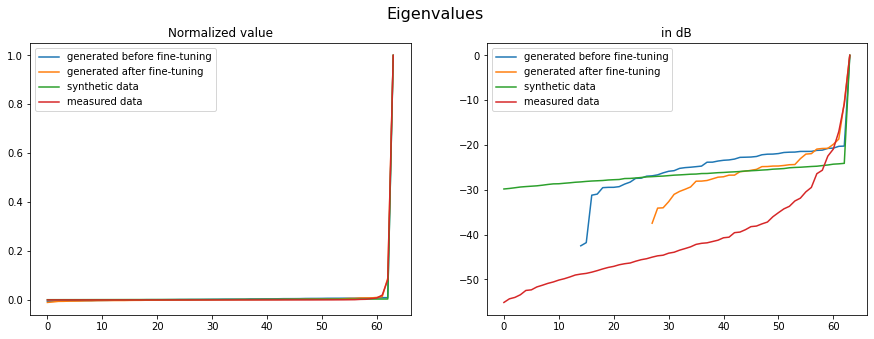

In [15]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, meas_evals = evals_wgangp.generate_evals(nb_trial=10)

meas_evals = np.sort(np.array(meas_evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
meas_evals_dB = levelify(meas_evals)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals, label="generated before fine-tuning")
plt.plot(meas_evals, label="generated after fine-tuning")
plt.plot(eval_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB, label="generated before fine-tuning")
plt.plot(meas_evals_dB, label="generated after fine-tuning")
plt.plot(eval_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

### Generating eigenvalues from level values (i.e. [dB] values)
First step is creating the Wasserstein GAN and training it with synthetic data

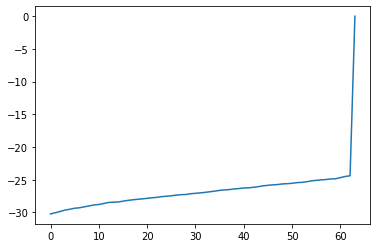

In [16]:
# First plot data about to be fed:
plt.plot(np.array(evals_dB_dataset[0,:,:,0]).flatten())

In [17]:
# Generating eigenvalues

# Creating GAN
evals_dB_wgangp = evals_dB_WGANGP()

# Compiling GAN
evals_dB_wgangp.compile()

# Getting directories for callbacks
filename = "evals_dB_wgangp" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


inverse_evals_dB_dataset = -1*evals_dB_dataset 
# Training GAN
evals_dB_wgangp.fit(
    evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_SYNTHETIC_BATCH,
    steps_per_epoch=20,
    callbacks=[tensorboard_callback, checkpoint_callback]
)



Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 8, 8, 1)]         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
multiply (Multiply)          (16, 64)                  0         
_________________________________________________________________
dense_7 (Dense)              (16, 512)                 33280     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (16, 512)                 0         
_________________________________________________________________
dense_8 (Dense)              (16, 256)                 131328    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (16, 256)                 0    

20/20 [==============================] - 0s 9ms/step - c_loss: -84.6653 - g_loss: 7.9752
Epoch 127/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -81.7813 - g_loss: -1.7900
Epoch 128/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -82.1132 - g_loss: -0.7519
Epoch 129/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -82.5820 - g_loss: -6.7933
Epoch 130/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -83.4520 - g_loss: -4.1664
Epoch 131/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -82.8042 - g_loss: 1.9578
Epoch 132/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.2528 - g_loss: -1.4835
Epoch 133/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -83.5966 - g_loss: -6.3566
Epoch 134/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -84.4723 - g_loss: 9.7341
Epoch 135/1000
20/20 [==============================] - 0s 7ms/step - c_l

20/20 [==============================] - 0s 8ms/step - c_loss: -79.1985 - g_loss: -16.0384
Epoch 283/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -87.5562 - g_loss: 13.3438
Epoch 284/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -86.2396 - g_loss: -18.8017
Epoch 285/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -88.4812 - g_loss: 3.9268
Epoch 286/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -88.1846 - g_loss: -3.5396
Epoch 287/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -79.3377 - g_loss: -3.4191
Epoch 288/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -74.3543 - g_loss: 1.3593
Epoch 289/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -81.6694 - g_loss: -11.7156
Epoch 290/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -88.5848 - g_loss: -0.8006
Epoch 291/1000
20/20 [==============================] - 0s 9ms/step -

20/20 [==============================] - 0s 8ms/step - c_loss: -85.7112 - g_loss: -16.7651
Epoch 361/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -81.1315 - g_loss: -6.4419
Epoch 362/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -84.9224 - g_loss: 9.1007
Epoch 363/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -86.1923 - g_loss: -20.1965
Epoch 364/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -87.0577 - g_loss: -2.6060
Epoch 365/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -85.2059 - g_loss: -1.7506
Epoch 366/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -83.7007 - g_loss: -10.4974
Epoch 367/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -74.7678 - g_loss: -12.9921
Epoch 368/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.8576 - g_loss: 0.6901
Epoch 369/1000
20/20 [==============================] - 0s 9ms/step 

20/20 [==============================] - 0s 7ms/step - c_loss: -79.8486 - g_loss: -8.2061
Epoch 516/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -89.9203 - g_loss: -11.8093
Epoch 517/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -76.2952 - g_loss: -17.1932
Epoch 518/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -86.6243 - g_loss: -21.0226
Epoch 519/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -80.5335 - g_loss: -1.9652
Epoch 520/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -84.5728 - g_loss: 6.8473
Epoch 521/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -84.5393 - g_loss: -0.2852
Epoch 522/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -79.7276 - g_loss: -12.0984
Epoch 523/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -85.8954 - g_loss: -20.8822
Epoch 524/1000
20/20 [==============================] - 0s 9ms/ste

20/20 [==============================] - 0s 9ms/step - c_loss: -84.1694 - g_loss: 14.0245
Epoch 670/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.7613 - g_loss: -16.5957
Epoch 671/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -81.7082 - g_loss: -6.5723
Epoch 672/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -82.1757 - g_loss: -11.3072
Epoch 673/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -88.4040 - g_loss: -6.3877
Epoch 674/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -93.2999 - g_loss: 0.6144
Epoch 675/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -79.6452 - g_loss: -12.3369
Epoch 676/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -85.4350 - g_loss: 13.6173
Epoch 677/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -85.0982 - g_loss: -14.5575
Epoch 678/1000
20/20 [==============================] - 0s 9ms/step

20/20 [==============================] - 0s 9ms/step - c_loss: -85.7620 - g_loss: -12.6844
Epoch 824/1000
20/20 [==============================] - 0s 10ms/step - c_loss: -81.1541 - g_loss: -8.7240
Epoch 825/1000
20/20 [==============================] - 0s 10ms/step - c_loss: -80.4986 - g_loss: -25.4831
Epoch 826/1000
20/20 [==============================] - 0s 10ms/step - c_loss: -90.9343 - g_loss: -15.1375
Epoch 827/1000
20/20 [==============================] - 0s 10ms/step - c_loss: -88.7211 - g_loss: -22.0075
Epoch 828/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -81.6168 - g_loss: 2.8526
Epoch 829/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -85.2171 - g_loss: -16.6078
Epoch 830/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -89.2066 - g_loss: -8.9392
Epoch 831/1000
20/20 [==============================] - 0s 8ms/step - c_loss: -86.6886 - g_loss: -22.8127
Epoch 832/1000
20/20 [==============================] - 0s 8m

20/20 [==============================] - 0s 10ms/step - c_loss: -81.0557 - g_loss: -5.5874
Epoch 978/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -79.6357 - g_loss: -18.8141
Epoch 979/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.4467 - g_loss: -6.0148
Epoch 980/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.7082 - g_loss: -16.0544
Epoch 981/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.5204 - g_loss: 6.3878
Epoch 982/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -79.4031 - g_loss: -3.8839
Epoch 983/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -77.8635 - g_loss: -15.6588
Epoch 984/1000
20/20 [==============================] - 0s 10ms/step - c_loss: -78.2077 - g_loss: -13.5188
Epoch 985/1000
20/20 [==============================] - 0s 9ms/step - c_loss: -80.0076 - g_loss: -9.8472
Epoch 986/1000
20/20 [==============================] - 0s 11ms/s

In [18]:
# Generating fake sample (before fine-tuning)

_, bft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

bft_evals_dB = np.array(bft_evals_dB[0, :, :, 0]).flatten() # convert sample from (1,8,8,1) to (64,)
bft_evals = unlevelify(bft_evals_dB)

tf.Tensor(23.796005, shape=(), dtype=float32)
real eigenvalues found


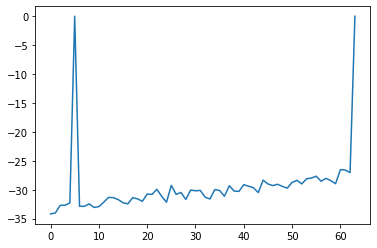

In [19]:
plt.plot(bft_evals_dB)

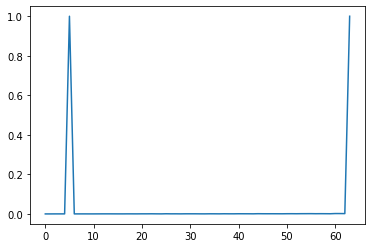

In [20]:
plt.plot(bft_evals)

The second step is to train further the Wasserstein GAN using this time really measurement

In [21]:
evals_dB_wgangp.fit(
    measurement_evals_dB_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=20,
    #callbacks=[tensorboard_callback, checkpoint_callback]
)

Epoch 1/200
20/20 [==============================] - 0s 9ms/step - c_loss: -325.5997 - g_loss: -551.5914
Epoch 2/200
20/20 [==============================] - 0s 9ms/step - c_loss: -201.5063 - g_loss: 2.2723
Epoch 3/200
20/20 [==============================] - 0s 9ms/step - c_loss: -203.8557 - g_loss: -36.9954
Epoch 4/200
20/20 [==============================] - 0s 9ms/step - c_loss: -217.3354 - g_loss: 14.1210
Epoch 5/200
20/20 [==============================] - 0s 9ms/step - c_loss: -233.6450 - g_loss: -1.3845
Epoch 6/200
20/20 [==============================] - 0s 9ms/step - c_loss: -230.1214 - g_loss: -1.1715
Epoch 7/200
20/20 [==============================] - 0s 9ms/step - c_loss: -219.7436 - g_loss: -31.3981
Epoch 8/200
20/20 [==============================] - 0s 9ms/step - c_loss: -212.9240 - g_loss: 7.5772
Epoch 9/200
20/20 [==============================] - 0s 9ms/step - c_loss: -212.4135 - g_loss: -21.7150
Epoch 10/200
20/20 [==============================] - 0s 9ms/step - c_

Epoch 157/200
20/20 [==============================] - 0s 9ms/step - c_loss: -235.8002 - g_loss: -25.8495
Epoch 158/200
20/20 [==============================] - 0s 9ms/step - c_loss: -241.9839 - g_loss: -30.2548
Epoch 159/200
20/20 [==============================] - 0s 8ms/step - c_loss: -234.5106 - g_loss: -3.5376
Epoch 160/200
20/20 [==============================] - 0s 9ms/step - c_loss: -246.7331 - g_loss: -41.3539
Epoch 161/200
20/20 [==============================] - 0s 9ms/step - c_loss: -250.8614 - g_loss: 11.7399
Epoch 162/200
20/20 [==============================] - 0s 9ms/step - c_loss: -246.0081 - g_loss: -3.5062
Epoch 163/200
20/20 [==============================] - 0s 9ms/step - c_loss: -238.5791 - g_loss: -35.3257
Epoch 164/200
20/20 [==============================] - 0s 8ms/step - c_loss: -210.0753 - g_loss: -15.1606
Epoch 165/200
20/20 [==============================] - 0s 9ms/step - c_loss: -266.1423 - g_loss: -40.1312
Epoch 166/200
20/20 [============================

Finally the obtained samples can be plotted

index=3286
index=1935
tf.Tensor(187.08891, shape=(), dtype=float32)
real eigenvalues found


Text(0.5, 0.98, 'Eigenvalues')

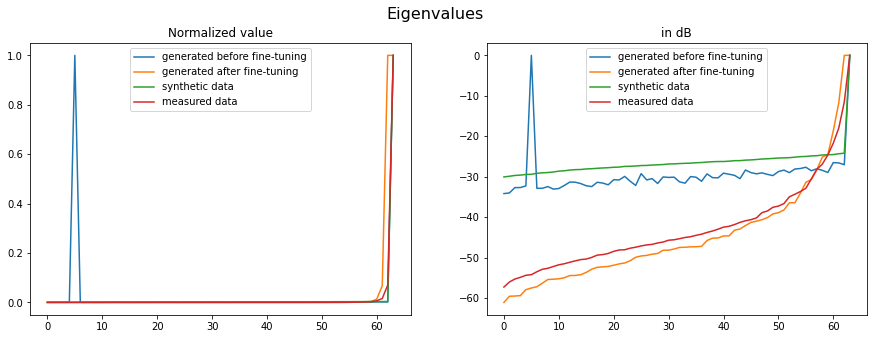

In [22]:
# Creating and plotting fake sample after fine-tuning

# Getting data from dataset
random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

evals_ex = normalize_evals(evals_dataset[random_index])
evals_ex = np.sort(np.array(evals_ex[:, :, 0]).flatten())
evals_ex_dB = levelify(evals_ex)

# Example:
random_index = random.randint(0, measurement_evals_dataset.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_dataset[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)




_, aft_evals_dB = evals_dB_wgangp.generate_evals(nb_trial=10)

aft_evals_dB = np.sort(np.array(aft_evals_dB[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
aft_evals = unlevelify(aft_evals_dB)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(bft_evals, label="generated before fine-tuning")
plt.plot(aft_evals, label="generated after fine-tuning")
plt.plot(evals_ex, label="synthetic data")
plt.plot(measurement_evals_ex, label="measured data")
plt.legend()


plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(bft_evals_dB, label="generated before fine-tuning")
plt.plot(aft_evals_dB, label="generated after fine-tuning")
plt.plot(evals_ex_dB, label="synthetic data")
plt.plot(measurement_evals_ex_dB, label="measured data")
plt.legend()

fig.suptitle('Eigenvalues', fontsize=16)

### Generating Eigenvectors (main+noise) 

Training on synthetic data

In [ ]:
# Generating main component of eigenvectors

# Creating GAN
main_evecs_wgangp = main_evecs_WGANGP()

# Compiling GAN
main_evecs_wgangp.compile()

# Getting directories for callbacks
filename = "main_evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
main_evecs_wgangp.fit(
    main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_SYNTHETIC_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.

Epoch 1/1000
5/5 [==============================] - 4s 145ms/step - c_loss: 0.4468 - g_loss: -0.2546
Epoch 2/1000
5/5 [==============================] - 0s 7ms/step - c_loss: 0.3207 - g_loss: -0.4576
Epoch 3/1000
5/5 [==============================] - 0s 7ms/step - c_loss: 0.0569 - g_loss: -0.3204
Epoch 4/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.3173 - g_loss: -0.0140
Epoch 5/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.4997 - g_loss: 0.1558
Epoch 6/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.6642 - g_loss: 0.3086
Epoch 7/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.6562 - g_loss: 0.3784
Epoch 8/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.6394 - g_loss: 0.3515
Epoch 9/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.5105 - g_loss: 0.2794
Epoch 10/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.3767 - g_loss: 0.2204
Epoch

5/5 [==============================] - 0s 10ms/step - c_loss: -0.0997 - g_loss: 0.1895
Epoch 83/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0744 - g_loss: 0.2110
Epoch 84/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1835 - g_loss: 0.2779
Epoch 85/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1047 - g_loss: 0.3332
Epoch 86/1000
5/5 [==============================] - 0s 11ms/step - c_loss: -0.1323 - g_loss: 0.3182
Epoch 87/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0844 - g_loss: 0.2808
Epoch 88/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1106 - g_loss: 0.2716
Epoch 89/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1347 - g_loss: 0.2614
Epoch 90/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1190 - g_loss: 0.2702
Epoch 91/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0950 - g_loss: 0.3021
Epoch 92

5/5 [==============================] - 0s 11ms/step - c_loss: -0.1314 - g_loss: 0.3122
Epoch 164/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1397 - g_loss: 0.2879
Epoch 165/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1019 - g_loss: 0.2884
Epoch 166/1000
5/5 [==============================] - 0s 11ms/step - c_loss: -0.1020 - g_loss: 0.2837
Epoch 167/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0926 - g_loss: 0.2917
Epoch 168/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1100 - g_loss: 0.2713
Epoch 169/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1173 - g_loss: 0.2466
Epoch 170/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1106 - g_loss: 0.2500
Epoch 171/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0805 - g_loss: 0.2143
Epoch 172/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1041 - g_loss: 0.2052
Ep

5/5 [==============================] - 0s 9ms/step - c_loss: -0.0988 - g_loss: 0.2827
Epoch 245/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1049 - g_loss: 0.2965
Epoch 246/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1398 - g_loss: 0.3103
Epoch 247/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1242 - g_loss: 0.2849
Epoch 248/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0840 - g_loss: 0.2959
Epoch 249/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1266 - g_loss: 0.3151
Epoch 250/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1167 - g_loss: 0.2670
Epoch 251/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1014 - g_loss: 0.2384
Epoch 252/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0957 - g_loss: 0.2140
Epoch 253/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0917 - g_loss: 0.2267
Epoch

5/5 [==============================] - 0s 8ms/step - c_loss: -0.1215 - g_loss: 0.3606
Epoch 326/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1054 - g_loss: 0.3580
Epoch 327/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1362 - g_loss: 0.3223
Epoch 328/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0962 - g_loss: 0.3120
Epoch 329/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1308 - g_loss: 0.3414
Epoch 330/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0940 - g_loss: 0.3560
Epoch 331/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1026 - g_loss: 0.4006
Epoch 332/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1211 - g_loss: 0.4169
Epoch 333/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1238 - g_loss: 0.3374
Epoch 334/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1284 - g_loss: 0.3177
Epoc

5/5 [==============================] - 0s 9ms/step - c_loss: -0.1027 - g_loss: 0.3243
Epoch 406/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1013 - g_loss: 0.3450
Epoch 407/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0988 - g_loss: 0.3792
Epoch 408/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1061 - g_loss: 0.3834
Epoch 409/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0898 - g_loss: 0.3887
Epoch 410/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1295 - g_loss: 0.4014
Epoch 411/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1077 - g_loss: 0.3877
Epoch 412/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1158 - g_loss: 0.3834
Epoch 413/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1040 - g_loss: 0.3969
Epoch 414/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1231 - g_loss: 0.3958
Epoc

5/5 [==============================] - 0s 7ms/step - c_loss: -0.1182 - g_loss: 0.5411
Epoch 487/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0998 - g_loss: 0.4808
Epoch 488/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1071 - g_loss: 0.5663
Epoch 489/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1298 - g_loss: 0.5537
Epoch 490/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1179 - g_loss: 0.5282
Epoch 491/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1077 - g_loss: 0.5280
Epoch 492/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1341 - g_loss: 0.5306
Epoch 493/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1065 - g_loss: 0.4968
Epoch 494/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.1201 - g_loss: 0.4781
Epoch 495/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1003 - g_loss: 0.4725
Epo

5/5 [==============================] - 0s 8ms/step - c_loss: -0.0967 - g_loss: 0.4890
Epoch 568/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1121 - g_loss: 0.5005
Epoch 569/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0881 - g_loss: 0.5178
Epoch 570/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1534 - g_loss: 0.5534
Epoch 571/1000
5/5 [==============================] - 0s 6ms/step - c_loss: -0.1524 - g_loss: 0.5086
Epoch 572/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1260 - g_loss: 0.4913
Epoch 573/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0878 - g_loss: 0.4563
Epoch 574/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1277 - g_loss: 0.4856
Epoch 575/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1176 - g_loss: 0.5181
Epoch 576/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0728 - g_loss: 0.5289
Epoch

5/5 [==============================] - 0s 9ms/step - c_loss: -0.1495 - g_loss: 0.4651
Epoch 649/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0967 - g_loss: 0.4403
Epoch 650/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0814 - g_loss: 0.4620
Epoch 651/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0805 - g_loss: 0.5143
Epoch 652/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1203 - g_loss: 0.5471
Epoch 653/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1226 - g_loss: 0.5469
Epoch 654/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1067 - g_loss: 0.5317
Epoch 655/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1178 - g_loss: 0.5335
Epoch 656/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0873 - g_loss: 0.5395
Epoch 657/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0940 - g_loss: 0.5017
Epo

5/5 [==============================] - 0s 8ms/step - c_loss: -0.1161 - g_loss: 0.5139
Epoch 730/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1294 - g_loss: 0.4982
Epoch 731/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1192 - g_loss: 0.4974
Epoch 732/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0843 - g_loss: 0.4828
Epoch 733/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1233 - g_loss: 0.5366
Epoch 734/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1360 - g_loss: 0.5460
Epoch 735/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1315 - g_loss: 0.5162
Epoch 736/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1006 - g_loss: 0.5025
Epoch 737/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1085 - g_loss: 0.4357
Epoch 738/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0903 - g_loss: 0.4413
Epoch

5/5 [==============================] - 0s 7ms/step - c_loss: -0.0843 - g_loss: 0.5049
Epoch 811/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0692 - g_loss: 0.4887
Epoch 812/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.1018 - g_loss: 0.4586
Epoch 813/1000
5/5 [==============================] - 0s 6ms/step - c_loss: -0.1253 - g_loss: 0.4367
Epoch 814/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1112 - g_loss: 0.4778
Epoch 815/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0851 - g_loss: 0.4756
Epoch 816/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1042 - g_loss: 0.4998
Epoch 817/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0953 - g_loss: 0.4831
Epoch 818/1000
5/5 [==============================] - 0s 10ms/step - c_loss: -0.0906 - g_loss: 0.5290
Epoch 819/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1158 - g_loss: 0.4931
Epo

5/5 [==============================] - 0s 9ms/step - c_loss: -0.0574 - g_loss: 0.4931
Epoch 892/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1204 - g_loss: 0.5053
Epoch 893/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1092 - g_loss: 0.5492
Epoch 894/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.1009 - g_loss: 0.5316
Epoch 895/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0719 - g_loss: 0.5169
Epoch 896/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0890 - g_loss: 0.5209
Epoch 897/1000
5/5 [==============================] - 0s 9ms/step - c_loss: -0.0773 - g_loss: 0.5033
Epoch 898/1000
5/5 [==============================] - 0s 7ms/step - c_loss: -0.0778 - g_loss: 0.5452
Epoch 899/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.1023 - g_loss: 0.5340
Epoch 900/1000
5/5 [==============================] - 0s 8ms/step - c_loss: -0.0783 - g_loss: 0.5217
Epoch

In [ ]:
# Generating noise component of eigenvectors

# Creating GAN
noise_evecs_wgangp = noise_evecs_WGANGP()

# Compiling GAN
noise_evecs_wgangp.compile()

# Getting directories for callbacks
filename = "noise_evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )




# Training GAN
noise_evecs_wgangp.fit(
    noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_SYNTHETIC_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)

Generating eigenvectors before fine-tuning

In [ ]:
# Creating and plotting fake sample

_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

Fine-tuning with measurements

In [ ]:
# main
print("training WGAN-GP for generating main eigenvector")
print("")
main_evecs_wgangp.fit(
    measurement_main_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
print("")
print("")
print("training WGAN-GP for generating noise eigenvectors")
print("")
# noise
"""
noise_evecs_wgangp.fit(
    measurement_noise_evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_MEASUREMENT_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
"""

Plotting Eigenvectors (after fine-tuning) 

In [ ]:
_, noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
_, main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)

evecs = tf.concat([noise_evecs, main_evecs],axis=-3)


evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)
plt.colorbar()

fig.suptitle('Eigenvectors', fontsize=16)

# Performing beamforming on fully generated data

In [ ]:
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
#_, generated_noise_evecs = noise_evecs_wgangp.generate_evecs(nb_trial=10)
generated_noise_evecs = measurement_noise_evecs_dataset[0] #TODO: delete
_, generated_main_evecs = main_evecs_wgangp.generate_evecs(nb_trial=10)
generated_main_evecs = generated_main_evecs[0,:,:,:] #TODO: delete

generated_evecs = tf.concat([generated_noise_evecs, generated_main_evecs], axis=-3)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
#evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
#evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample
evecs_real = generated_evecs[ :, :, 0] #TODO: delete
evecs_imag = generated_evecs[ :, :, 1] #TODO: delete


csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

# Data augmentation

In [ ]:
from data_augmentation import get_augmentented_dataset

evecs_subdataset = evecs_dataset[:1,:,:,:]

augmented_sample_dataset = get_augmentented_dataset(
                            evals_dataset=evals_dataset,
                            batch_size=BATCH_SIZE,
                            nb_batch=NB_BATCH,
                            steps_per_epoch=NB_STEPS,
                            evecs_dataset=evecs_subdataset,
                            size_augmentation=10
                            )

augmented_evecs_dataset = tf.convert_to_tensor([s[0] for s in augmented_sample_dataset])
augmented_evals_dataset = tf.convert_to_tensor([s[1] for s in augmented_sample_dataset])

In [ ]:
print(augmented_evals_dataset.shape)
print(augmented_evecs_dataset.shape)

In [ ]:
from beamforming import beamform, get_csm

NUMFREQ = 1
NUMCHANNELS = 64

augmented_evals = augmented_evals_dataset[0,:,:,:]
augmented_evecs = augmented_evecs_dataset[0,:,:,:]

evals_vec_numpy = np.sort(np.array(augmented_evals[0,:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy) 

evecs_real = augmented_evecs[:,:,0]
evecs_imag = augmented_evecs[:,:,1]

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)

# Everything below is outdated

===================================================================================================

### Opening real measurement

from mail: Note that the files stem from two different measurements with different loudspeakers (see pictures). In one case, the samplerate is 25.6 kHz and in the other case it is 51.2 kHz. Each measurement was performed for 10 seconds.

Currently, the measured data only include 51 different source cases. You can augment the dataset by simply using different time sections from each measurement to calculate the CSM (or/and by varying parameters such as the block size, window, and overlap).

about the samples:
- length: 10s
- sample rate: either 25.6 kHz or 51.2 kHz
- position: always different (51 different position)
- format: .h5

In [ ]:
"""
from measurement import get_measurement_batch
import tensorflow as tf
from eigenmanipulation import normalize_evals
import random
import matplotlib.pyplot as plt

measurement_path = "../Data/Measurement/td/"
measurement_path_c4 = "../../../shared/measured_data/td/"
filename = "2021-03-19_14-28-01_611275.h5"

measurement_name = f"{measurement_path_c4}{filename}"

print(measurement_name)

measurement_batch = get_measurement_batch(
                                        measurement_name=measurement_name, 
                                        batch_size=16
                                        )


measurement_evecs_batch = tf.convert_to_tensor([m[0] for m in measurement_batch])
measurement_evals_batch = tf.convert_to_tensor([m[1] for m in measurement_batch])



# Print example:
random_index = random.randint(0, measurement_evals_batch.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_batch[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(measurement_evals_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(measurement_evals_ex_dB)

fig.suptitle('Measured eigenvalues', fontsize=16)
"""

In [ ]:
"""
from eigenmanipulation import normalize_evals
import random
import matplotlib.pyplot as plt

# Example:
random_index = random.randint(0, measurement_evals_batch.shape[0]-1)
print(f"index={random_index}")
measurement_evals_ex = measurement_evals_batch[random_index]

measurement_evals_ex = normalize_evals(measurement_evals_ex)
measurement_evals_ex = np.sort(np.array(measurement_evals_ex[:, :, 0]).flatten())
measurement_evals_ex_dB = levelify(measurement_evals_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(measurement_evals_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(measurement_evals_ex_dB)

fig.suptitle('Measured eigenvalues', fontsize=16)
"""

### Init: importing libraries and creating datasets

In [ ]:
"""
# Imports
import tensorflow as tf # tensorflow 2.10
import numpy as np # numpy 1.21.5
import matplotlib.pyplot as plt
from data_generation import get_sample
from evals_WGANGP import evals_WGANGP
from evecs_WGANGP import evecs_WGANGP
import datetime

# General variable
BATCH_SIZE = 16
NB_BATCH = 200
TRAINING_SET_SIZE = BATCH_SIZE*NB_BATCH
NB_STEPS = 20
"""

In [ ]:
"""
# Generating dataset
sample_dataset = [get_sample() for _ in range(TRAINING_SET_SIZE)]
evecs_dataset = tf.convert_to_tensor([s[0] for s in sample_dataset])
evals_dataset = tf.convert_to_tensor([s[1] for s in sample_dataset])

In [ ]:
# Print model's architecture:
"""
evals_wgangp = evals_WGANGP()
evals_wgangp.compile()

model_critic_evals = evals_wgangp.critic
model_generator_evals = evals_wgangp.generator

evecs_wgangp = evecs_WGANGP()
evecs_wgangp.compile()

model_critic_evecs = evecs_wgangp.critic
model_generator_evecs = evecs_wgangp.generator

models = [  (model_critic_evals, "model_critic_evals"), 
            (model_generator_evals, "model_generator_evals"),
            (model_critic_evecs, "model_critic_evecs"),
            (model_generator_evecs,"model_generator_evecs")
        ]

for model, name in models:
    tf.keras.utils.plot_model(
        model,
        to_file=f"{name}.png",
        show_shapes=False,
        show_dtype=False,
        show_layer_names=True,
        rankdir="TB",
        expand_nested=False,
        dpi=96,
        layer_range=None,
        show_layer_activations=False,
    ) 
"""

### Print example of eigenvalues

In [ ]:
from eigenmanipulation import normalize_evals
import random


random_index = random.randint(0, evals_dataset.shape[0]-1)
print(f"index={random_index}")

eval_ex = normalize_evals(evals_dataset[random_index])
eval_ex = np.sort(np.array(eval_ex[:, :, 0]).flatten())
eval_ex_dB = levelify(eval_ex)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(eval_ex)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(eval_ex_dB)

fig.suptitle('Eigenvalues from dataset', fontsize=16)


### Print example of eigenvectors

In [ ]:
from eigenmanipulation import normalize_evecs
import random


random_index = random.randint(0, evecs_dataset.shape[0]-1)
print(f"index={random_index}")
evec_ex = normalize_evals(evecs_dataset[random_index])

evec_ex_real = evec_ex[:, :, 0] # get real part from sample
evec_ex_imag = evec_ex[:, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evec_ex_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evec_ex_imag)

fig.suptitle('Eigenvectors from dataset', fontsize=16)

### Initiating and training WGAN-GP for eigenvectors

In [ ]:
"""
# Generating eigenvectors

# Creating GAN
evecs_wgangp = evecs_WGANGP()

# Compiling GAN
evecs_wgangp.compile()

# Getting directories for callbacks
filename = "evecs_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )

# Training GAN
evecs_wgangp.fit(
    evecs_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)
# time for epoch=100, step=1, batch_size=16 -> approx 15min.
"""

In [ ]:
"""
# Creating and plotting fake sample
_, evecs = evecs_wgangp.generate_evecs(nb_trial=10)

evecs_real = evecs[0, :, :, 0] # get real part from sample
evecs_imag = evecs[0, :, :, 1] # get imaginary part from sample


fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Real part")
plt.imshow(evecs_real)

plt.subplot(1,2,2)
plt.title("Imaginary part")
plt.imshow(evecs_imag)

fig.suptitle('Eigenvectors', fontsize=16)
"""

### Initiating and training WGAN-GP for eigenvalues

In [ ]:
"""
# Generating eigenvalues

# Creating GAN
evals_wgangp = evals_WGANGP()

# Compiling GAN
evals_wgangp.compile()

# Getting directories for callbacks
filename = "evals_wgangp_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
log_dir = f"logs/{filename}"
checkpoint_dir = f"checkpoints/{filename}"

# Creating callbacks
tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                                    log_dir=log_dir,
                                                    histogram_freq=1
                                                    )
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                                    filepath=checkpoint_dir,
                                                    save_weights_only=True,
                                                    monitor='g_loss',
                                                    mode='min',
                                                    save_best_only=True
                                                    )


# Training GAN
evals_wgangp.fit(
    evals_dataset,
    batch_size=BATCH_SIZE,
    epochs=NB_BATCH,
    steps_per_epoch=NB_STEPS,
    callbacks=[tensorboard_callback, checkpoint_callback]
)



# time for epoch=100, step=5, batch_size=16 -> approx 18min.
# time for epoch=100, step=10, batch_size=16 -> approx 32min.
# time for epoch=100, step=20, batch_size=16 -> approx _min.
"""

In [ ]:
#print(checkpoint_dir)
#evals_wgangp.load_weights(checkpoint_dir)

In [ ]:
# Creating and plotting fake sample
"""
_, evals = evals_wgangp.generate_evals(nb_trial=10)

evals = np.sort(np.array(evals[0, :, :, 0]).flatten()) # convert sample from (1,8,8,1) to (64,)
evals_dB = levelify(evals)

fig = plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title("Normalized value")
plt.plot(evals)

plt.subplot(1,2,2)
plt.title("in dB")
plt.plot(evals_dB)

fig.suptitle('Eigenvalues', fontsize=16)
"""

### Performing Beamforming with generated samples

In [ ]:
"""
from beamforming import beamform, get_csm

_, generated_evals = evals_wgangp.generate_evals(nb_trial=10)
_, generated_evecs = evecs_wgangp.generate_evecs(nb_trial=10)

# reshape data
evals_vec_numpy = np.sort(np.array(generated_evals[0, :, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy)
evecs_real = generated_evecs[0, :, :, 0] # get real part from sample
evecs_imag = generated_evecs[0, :, :, 1] # get imaginary part from sample

"""
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
print(f"real_evecs_real.shape={evecs_real.shape}")
print(f"real_evecs_imag.shape={evecs_imag.shape}")
print(f"tmp_evals_vec.shape={evals_vec.shape}")
print("-=-=-=-=-=-=-=-=-=-=-=-=-")
"""

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()

NUMFREQ = 1 # one freq with index bin = 13 ? -> is that accurate ?
NUMCHANNELS = 64

csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)
"""

### Data augmentation 

In [ ]:
"""
from data_augmentation import get_augmentented_dataset

evecs_subdataset = evecs_dataset[:1,:,:,:]

augmented_sample_dataset = get_augmentented_dataset(
                            evals_dataset=evals_dataset,
                            batch_size=BATCH_SIZE,
                            nb_batch=NB_BATCH,
                            steps_per_epoch=NB_STEPS,
                            evecs_dataset=evecs_subdataset,
                            size_augmentation=10
                            )

augmented_evecs_dataset = tf.convert_to_tensor([s[0] for s in augmented_sample_dataset])
augmented_evals_dataset = tf.convert_to_tensor([s[1] for s in augmented_sample_dataset])

print(augmented_evals_dataset.shape)
print(augmented_evecs_dataset.shape)

from beamforming import beamform, get_csm

NUMFREQ = 1
NUMCHANNELS = 64

augmented_evals = augmented_evals_dataset[0,:,:,:]
augmented_evecs = augmented_evecs_dataset[0,:,:,:]

evals_vec_numpy = np.sort(np.array(augmented_evals[0,:, :, 0]).flatten())
evals_vec = tf.convert_to_tensor(evals_vec_numpy) 

evecs_real = augmented_evecs[:,:,0]
evecs_imag = augmented_evecs[:,:,1]

csm = get_csm(evecs_real, evecs_imag, evals_vec).numpy()
csm = np.reshape(csm, newshape=(NUMFREQ,NUMCHANNELS,NUMCHANNELS))

beamform(csm)
"""